In [45]:
import numpy as np
import pandas as pd
import random
import pickle
from config import DATA
from tqdm import tqdm

import netsurfp2 as nsp2
import matplotlib.pyplot as plt

from structure.utils import *
from structure.data_extraction import *

In [46]:
AMINO_ACIDS = AA = 'ACDEFGHIKLMNPQRSTVWY'
AA_INDEX = {k:i for i,k in enumerate(AA)}

## PFAM sequence extraction

In [49]:
DATASET = "PF00296"
folder = f"{DATA}/{DATASET}"

In [50]:
extract_data(folder, "full.fasta")

building sequences.csv
building aligned.fasta, unaligned.fasta ...
building clusters with MMSEQS.
computing cluster weights
split between training and validation set
make HMM profile
build HMM profiles


  0%|          | 386/82488 [00:13<48:33, 28.18it/s]


KeyboardInterrupt: 

In [51]:
structfam = get_structures(DATA, DATASET) 

In [52]:
pfam_seqs = pd.read_csv(f"{folder}/sequences.csv", index_col = 0, usecols = [0,2]).seq
pfam_seqs = {k.split("/")[0]:v for k,v in pfam_seqs.items()}

In [53]:
patterns, secondary_structure, c_patterns, n_patterns = build_patterns(pfam_seqs, structfam)

100%|██████████| 25/25 [00:08<00:00,  2.90it/s]


In [54]:
pfam_aligned_seqs = pd.read_csv(f"{folder}/sequences.csv", index_col = 0, usecols = [0,1]).aligned_seq
pfam_aligned_seqs = {k.split("/")[0]:np.array([int(i in AA) for i in v]) for k,v in pfam_aligned_seqs.items()}

In [56]:
N = len(list(pfam_aligned_seqs.values())[0])
N

1771


profiles



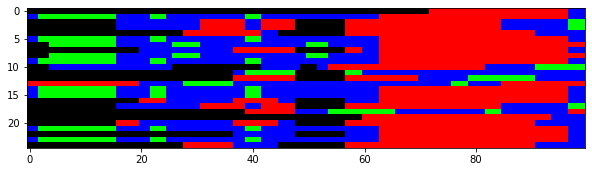

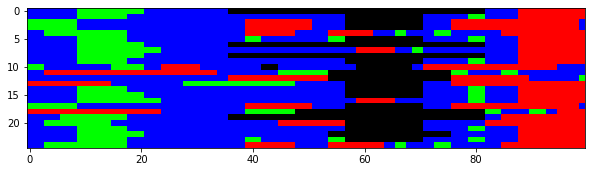

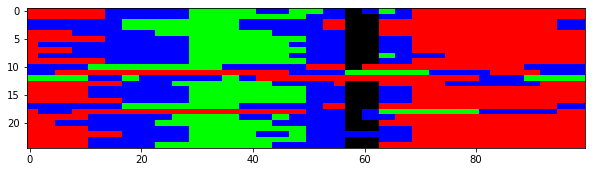

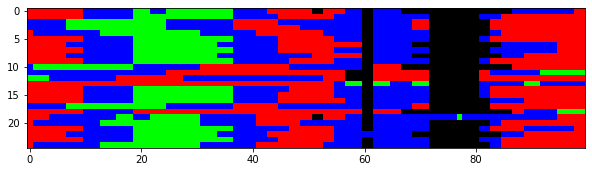

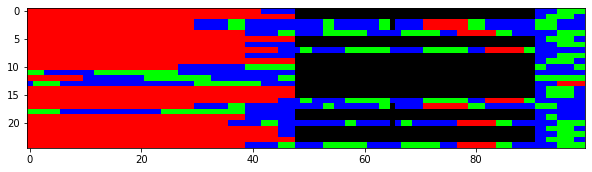

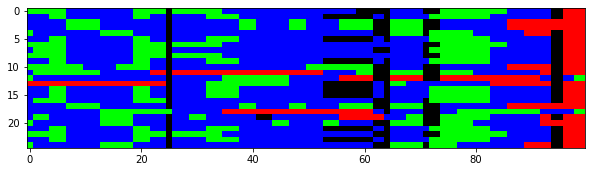

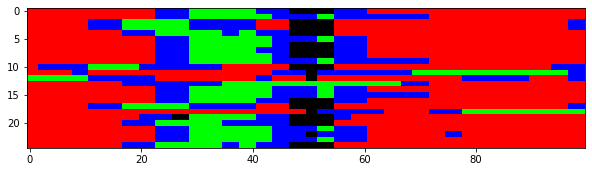

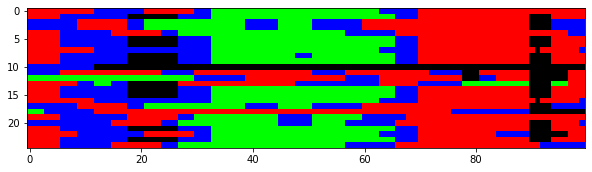

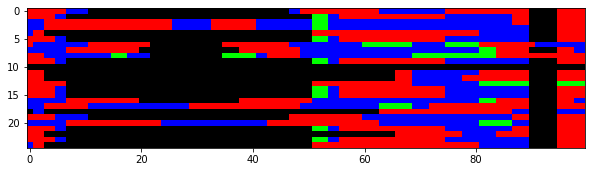

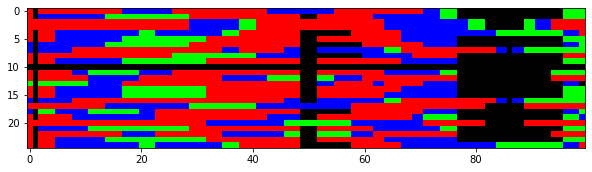

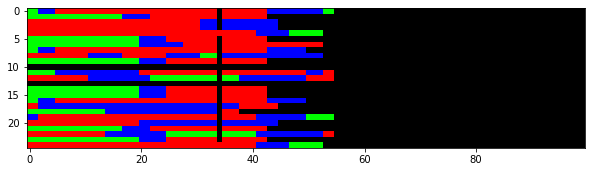


extended profile



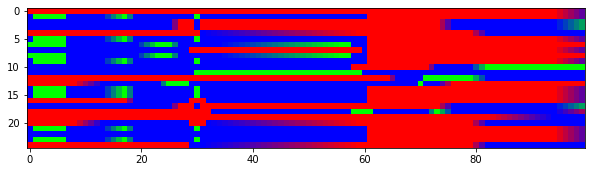

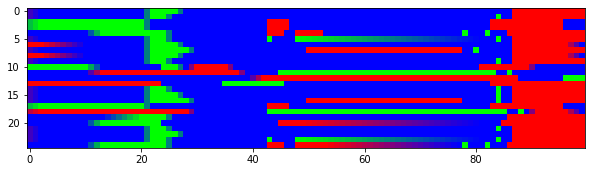

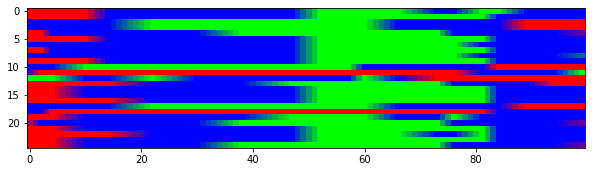

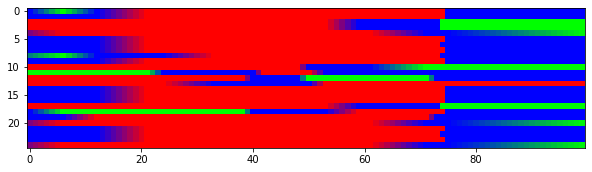

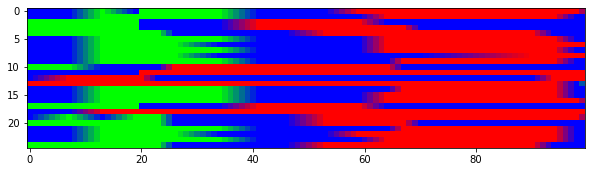

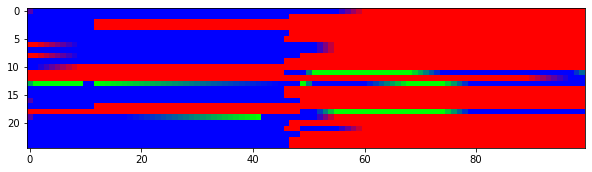

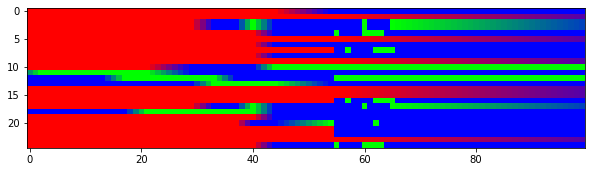

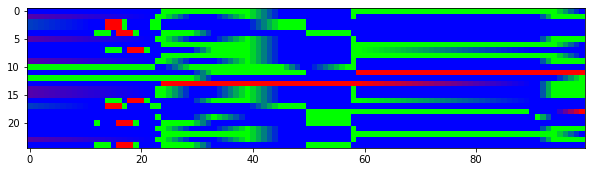

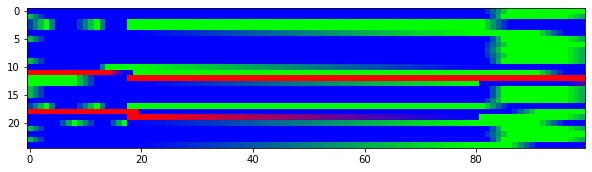

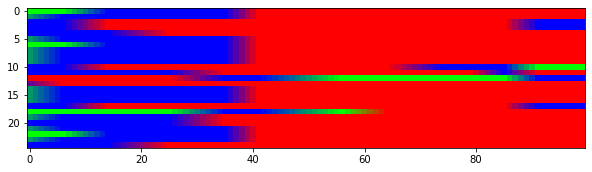

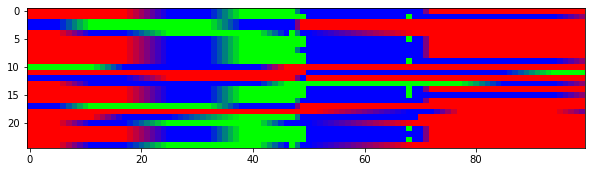

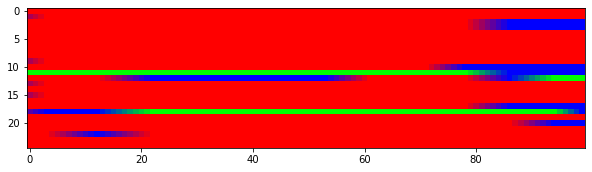

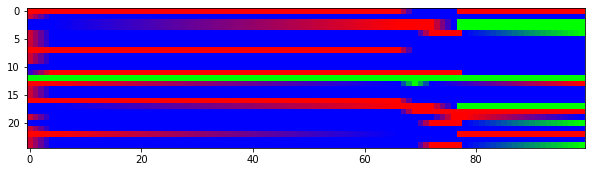

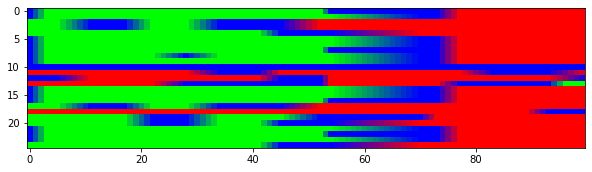

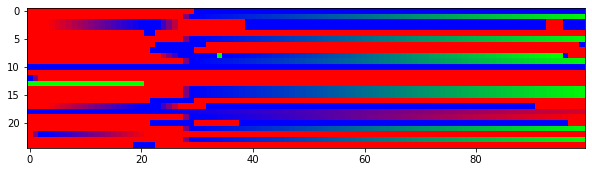

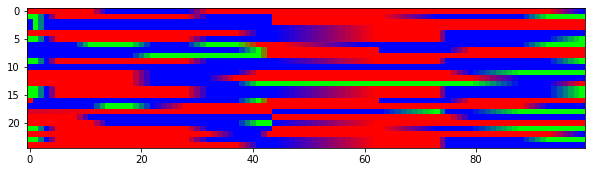

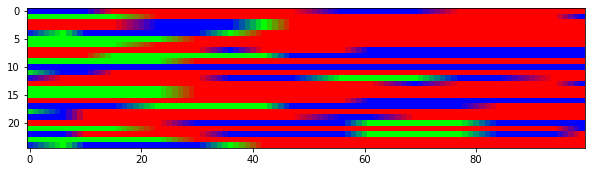

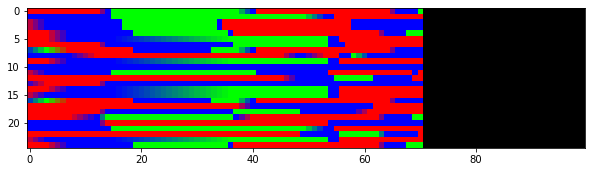


extended mean profile



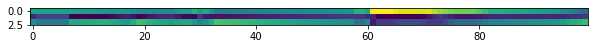

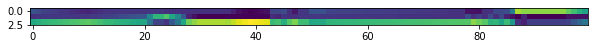

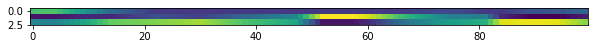

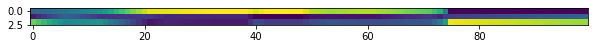

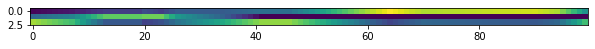

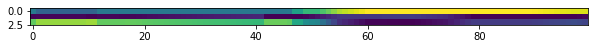

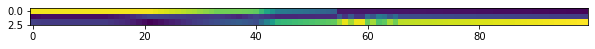

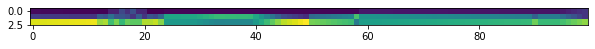

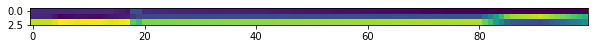

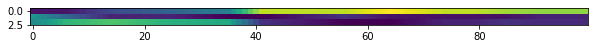

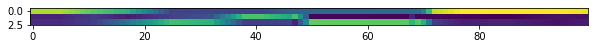

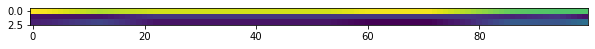

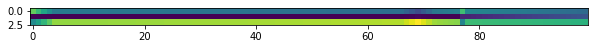

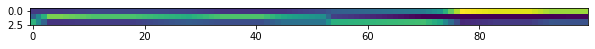

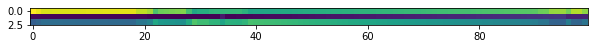

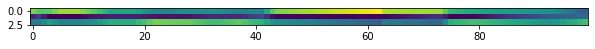

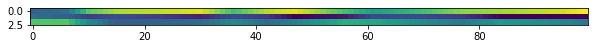

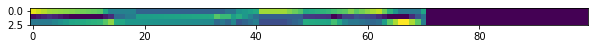


extended argmax profile



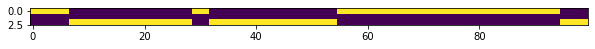

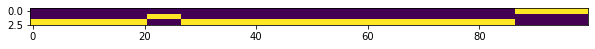

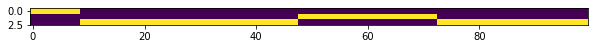

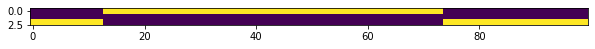

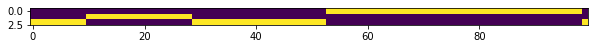

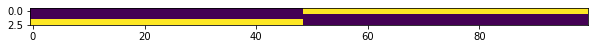

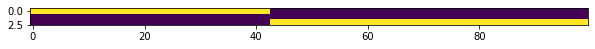

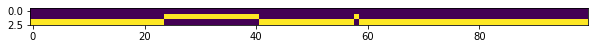

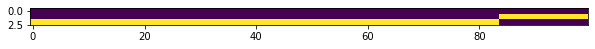

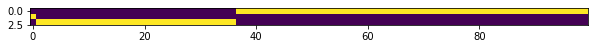

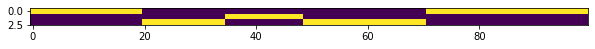

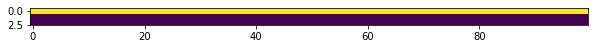

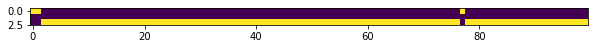

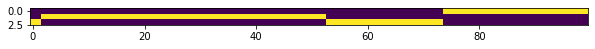

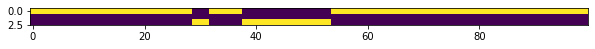

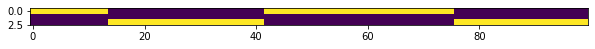

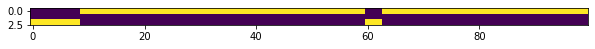

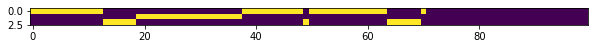

In [57]:
aligned_seqs = np.zeros((len(secondary_structure), 100*(N//100+1), 3))

weights=[]
idxs = []
for i, (k, (key, struct,secondary_number,pos_Y, weight)) in enumerate(secondary_structure.items()):
    idx = np.where(pfam_aligned_seqs[key] > 0)[0]
    idxs.append(idx)
    aligned_seqs[i, idx[pos_Y]] = to_onehot(struct, (None,3))
    weights.append(weight)
weights = np.array(weights)

aligned_seqs2 = np.zeros((len(secondary_structure), 100*(N//100+1), 3))
aligned_seqs2 = aligned_seqs.copy()
for k in range(len(secondary_structure)):
    idx = np.where(aligned_seqs[k]>0)[0]
    before, after, x, y, cursor = aligned_seqs[k,idx[0]], aligned_seqs[k,idx[1]], idx[0], idx[1], 2
    for i in range(N):
        if i < x:
            aligned_seqs2[k,i] = before
        elif i > y:
            aligned_seqs2[k,i] = after
        elif i == y and cursor < len(idx):
            x = y; y = idx[cursor]; cursor += 1
            before = after; after = aligned_seqs[k,y]
        elif i == x:
            ()
        else:
            t = (i-x)/(y-x)
            aligned_seqs2[k,i] = t*after + (1-t)*before

 
hotpoints = (aligned_seqs2*weights.reshape(-1,1,1)).sum(0).T
N2 = hotpoints.shape[-1]
hotpoints2 = np.zeros((3, (N2//100 + 1)*100))
hotpoints2[:, :hotpoints.shape[-1]] = hotpoints
idx = np.where(hotpoints2.sum(0)>0)[0]
before, after, x, y, cursor = hotpoints2[:,idx[0]], hotpoints2[:,idx[1]], idx[0], idx[1], 2
for i in range(N2//100 + 1):
    if i < x:
        hotpoints2[:,i] = before
    elif i > y:
        hotpoints2[:,i] = after
    elif i == y and cursor < len(idx):
        x = y; y = idx[cursor]; cursor += 1
        before = after; after = hotpoints2[:,y]
    elif i == x:
        ()
    else:
        t = (i-x)/(y-x)
        hotpoints2[:,i] = t*after + (1-t)*before
    
print(), print("profiles"), print()
idx = np.where(aligned_seqs.sum(0)>0)[0]
for i in range(len(idx)//100 + 1):
    plt.figure(figsize = (10,20))
    x = aligned_seqs[:,idx][:, 100*i:100*(i+1)]
    if x.shape[1] != 100:
        x = np.pad(x, ((0,0),(0,100-x.shape[1]), (0,0)))
    plt.imshow(x)
    plt.show()
    
print(), print("extended profile"), print()
for i in range(N//100 + 1):
    plt.figure(figsize = (10,20))
    x = aligned_seqs2[:, 100*i:100*(i+1)]
    plt.imshow(x)
    plt.show()
        
        
print(), print("extended mean profile"), print()
x = (1+hotpoints2)/(1+hotpoints2).sum(0)
x[:,N:] = 0
for i in range(N//100 + 1):
    plt.figure(figsize = (10, 3))
    plt.imshow(hotpoints2[:, 100*i:100*(i+1)])
    plt.show() 
hotpoints2 = (1+hotpoints2)/(1+hotpoints2).sum(0)

print(), print("extended argmax profile"), print()
x = to_onehot(hotpoints2.argmax(0), (None,3)).T
x[:,N:] = 0
for i in range(N//100 + 1):
    plt.figure(figsize = (10, 3))
    plt.imshow(x[:,100*i:100*(i+1)])
    plt.show()   

In [58]:
sse = to_onehot(hotpoints2[:,:N].argmax(0), (None,3))
ss = np.pad(sse, ((1,1),(0,0)), "constant")
dss = (ss[1:] - ss[:-1])
cls = to_onehot(np.where(dss == -1)[1], (None, 3)).T
bbox = np.array([np.where(dss == 1)[0], np.where(dss == -1)[0], *cls]).T
pat = np.argmax(bbox[:,2:],1)

c_patterns, n_patterns = [],[]
char_pat= "".join(["abc"[x] for x in pat])
if len(char_pat) and char_pat not in c_patterns:
    c_patterns.append(char_pat)
    n_patterns.append(list(pat))

In [59]:
ss_profile = np.log(hotpoints2[:,:N]).T

In [60]:
pickle.dump(ss_profile, open(f"{DATA}/{DATASET}/ss_profile.pkl", "wb"))
pickle.dump((n_patterns, c_patterns, list(patterns.keys())), open(f"{DATA}/{DATASET}/patterns.pkl", "wb"))

## Vizualization

In [27]:
from structure.graphics import visualize_secondary_structure
from structure.data_extraction import fetch_PDB
import matplotlib.pyplot as plt

5VZL


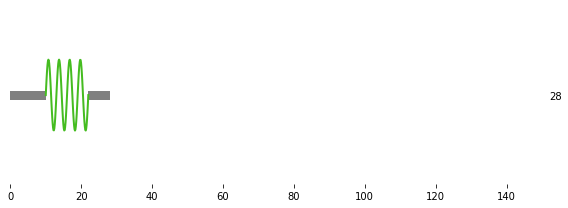

6K4S


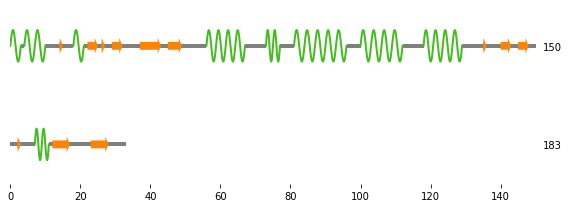

5XBL


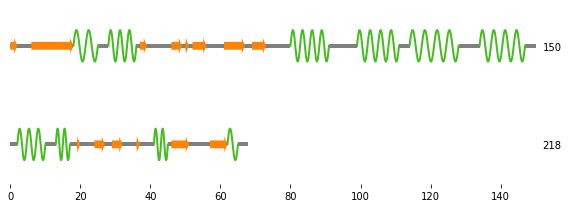

6MCB


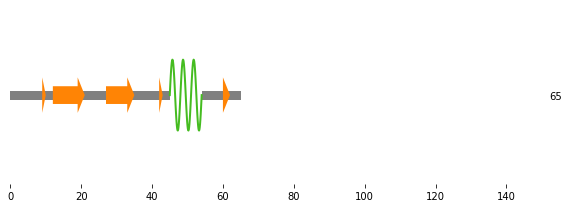

6MCC


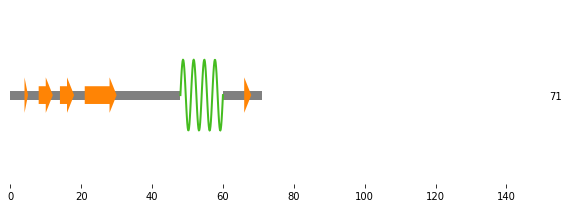

In [28]:
for pdb, pfam, c, start, end in structfam.values():
    try:
        print(pdb)
        sse, tk_mono = fetch_PDB(pdb, c, start, end+1)
        visualize_secondary_structure(sse, 0, 150)
        plt.show()
    except:
        print(pdb, pfam, c, start, end+1)

In [6]:
fetch_PDB('1YIU', 'A', 6, 35)

(array(['c', 'c', 'c', 'c', 'c', 'b', 'b', 'b', 'c', 'c', 'c', 'c', 'c',
        'b', 'b', 'b', 'b', 'b', 'c', 'c', 'c', 'c', 'b', 'b', 'b', 'c',
        'c', 'c', 'c'], dtype='<U1'),
 <biotite.structure.AtomArray at 0x7f2e04c0a310>)

In [1]:
from biotite.structure.io.pdb import get_structure

In [2]:
get_structure('1YIU', 'A', 6, 35)

AttributeError: 'str' object has no attribute 'get_structure'